In [2]:
## using importance sampling to calculate marginal likelihood for a hyperbolic model in intertemporal choice task
## from Vandekerckhove, J., et al. (2015). Model comparison and the principle of parsimony. The Oxford handbook of computational and mathematical psychology. New York, NY, US, Oxford University Press: 300-319.

In [3]:
import pymc3 as pm
import numpy as np
import arviz as az
import seaborn as sns
from scipy import stats
from scipy import optimize

In [4]:
## simulate data
# define stimulus information
ss_value = np.random.normal(40,3,80)
ll_value = np.copy(ss_value)
ll_value[0:20],ll_value[20:40],ll_value[40:60],ll_value[60:80] = ll_value[0:20]*1.1,ll_value[20:40]*1.3,ll_value[40:60]*1.5,ll_value[60:80]*1.7
np.random.shuffle(ll_value)
ss_time = np.repeat([0,10],40)
np.random.shuffle(ss_time)
ll_time = np.copy(ss_time)
ll_time[0:40],ll_time[40:80]=ll_time[0:40]+10,ll_time[40:80]+20

In [5]:
k = 0.04
beta = 2

In [6]:
def dd_model_rng(k,beta,ll_v,ll_t,ss_v,ss_t):
    dsv = ll_value/(1+k*ll_time)-ss_value / (1+k*ss_time)
    p_ll = 1/(1+np.exp(-beta*dsv))
    choice = np.random.binomial(n=1,p=p_ll)
    return choice

In [7]:
dd_sim_data = dd_model_rng(k,beta,ll_value,ss_value,ll_time,ss_time)

In [8]:
def sigmoid(beta, x):
    return 1/ (1 + pm.math.exp(-beta * x))

In [9]:
# define pymc3 model
with pm.Model() as dd_model:
    k_raw = pm.Normal('k_raw',0,1)
    beta_raw = pm.Normal('beta_raw',0,1)
    k = pm.Deterministic('k',pm.math.exp(k_raw))
    beta = pm.Deterministic('beta',pm.math.exp(beta_raw))
    sv_ll = pm.Deterministic('sv_ll', ll_value/ (1 + k * ll_time))
    sv_ss = pm.Deterministic('sv_ss', ss_value/ (1 + k * ss_time))  
    p = pm.Deterministic('p_ll', sigmoid(beta,sv_ll-sv_ss))
    y = pm.Bernoulli('y_choice',p = p, observed = dd_sim_data)
    tr = pm.sample()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_88296\1715610969.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  tr = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_raw, k_raw]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [10]:
data = az.convert_to_inference_data(tr)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\ProgramData\Anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [164]:
k = np.array(data.posterior['k']).flatten()
beta = np.array(data.posterior['beta_raw']).flatten()
combine_para = np.array([k,beta])

In [165]:
def sigmoid_tran(x,beta=1):
    return 1/(1+np.exp(-beta*x))

In [166]:
normal_ = stats.norm(0,1)
combine_para[1] = sigmoid_tran(combine_para[1],beta = 0.1)

C:\ProgramData\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

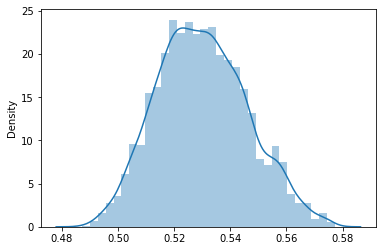

In [167]:
sns.distplot(combine_para[1])

In [168]:
## fit parameter posterior with beta distribution
## alpha,beta: parameters of beta distribution
## pdp: posterior distribution of parameteres
def beta_dist(alpha_beta,pdp):
    alpha,beta = alpha_beta[0],alpha_beta[1]
    beta_ = stats.beta(alpha,beta)
    normal_ = stats.norm(0,1)
    return -np.sum(np.log(beta_.pdf(pdp)))
# fit,using simplex method
# According to Alexandrowicz & Gula (2020), simplex has better parameter recovery than quasi-newtwon method.
fit_beta = np.zeros([2,2])
for index,number in enumerate(combine_para):
    llf_init = 0
    for n in range(20):
        x0 = np.random.uniform(0,1,2)
        result = optimize.minimize(fun = beta_dist,x0 = x0,args = number,method='Nelder-Mead')
        if result.fun < llf_init:
            llf_init = result.fun
            fit_beta[index,:] = result.x

In [169]:
fit_beta

array([[  999.94871298, 23353.20213597],
       [  510.37533257,   452.48715348]])

C:\ProgramData\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\envs\pymc_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

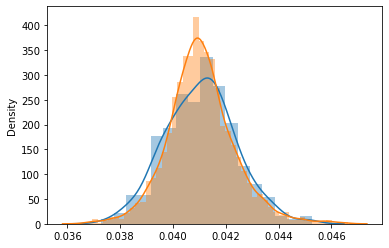

In [304]:
# show fitted beta distribution
sample_num = 25000
k_beta = stats.beta(fit_beta[0,0],fit_beta[0,1])
beta_beta = stats.beta(fit_beta[1,0], fit_beta[1,1])
k_beta_random = k_beta.rvs(400)
beta_beta_random = beta_beta.rvs(400)
sns.distplot(k_beta_random)
sns.distplot(combine_para[0])

In [305]:
def inverse_sigmoid(y,beta):
    dot_x = np.log(y/(1-y))
    x = dot_x/beta
    return x

In [306]:
## parameter sampled from a beta mixture proposal distribution
mixture_p = 0.1
theta_k = (1-mixture_p) * k_beta.rvs(sample_num) + mixture_p * np.random.uniform(0,1,sample_num)
theta_beta = (1-mixture_p) * beta_beta.rvs(sample_num) + mixture_p * np.random.uniform(0,1,sample_num)
theta_beta_trans = inverse_sigmoid(theta_beta,0.1)
theta_beta_ture = np.exp(theta_beta_trans)

In [307]:
# first thing to calculate is likelihood: p(theta|D)
def hyperbolic_lf(k,beta,ll_v,ll_t,ss_v,ss_t,choice):
    dsv = ll_value/(1+k*ll_time)-ss_value / (1+k*ss_time)
    p_ll = 1/(1+np.exp(-beta*dsv))
    lf = p_ll * choice + (1-choice)*(1-p_ll)
    return lf

In [308]:
lf = hyperbolic_lf(theta_k.reshape([sample_num,1]),theta_beta_ture.reshape([sample_num,1]),ll_value,ss_value,ll_time,ss_time,dd_sim_data)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_88296\786965592.py:4: RuntimeWarning: overflow encountered in exp
  p_ll = 1/(1+np.exp(-beta*dsv))


In [309]:
lf = np.prod(lf,axis=1)

In [310]:
# second thing to calcualte:prioir probability p(theta|Model)
theta_k_prior = np.log(theta_k)
theta_beta_prior = theta_beta_trans
prior = stats.norm(0,1)

In [311]:
prior_prob = prior.pdf(theta_k_prior)*prior.pdf(theta_beta_prior)

In [312]:
# third thing to calcualte is proposal probability:g(theta|Model)
propo_prob = k_beta.pdf(theta_k)*beta_beta.pdf(theta_beta)

In [313]:
## calculate marginal likelihood
#concat three probability density
concat_prob = np.array([lf,prior_prob,propo_prob])
idx = np.unique(np.where(concat_prob == 0)[1])
## toss out colmns has 0 value
concat_prob_ = np.delete(concat_prob,idx, axis=1)

In [316]:
ml = np.log(np.sum(concat_prob_[0] * concat_prob_[1] / concat_prob_[2])/len(concat_prob_))

In [321]:
print('log margnial likelihood for hyerbolic model is {:.2f}'.format(ml))

log margnial likelihood for hyerbolic model is 687.40
